In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

**Что имеем в наборе?**
Данные по продажам из магазина жидкостей.  
У нас есть:  
1. параметры стоимости за 1 литр жидкости
1. габариты упаковки
1. Кол-во продаж товара.

Наша задача:  
- Подобрать линейную регрессию, которая смотжет максимально точно описать распределение объема продаж в у.е. 

In [2]:
# Параметры
# Кол-во наблюдений
samples = 300

# Список товаров (и цен за литр) в нашей сети магазинов продуктовых жидкостей
product_details = ({
    "Молоко 'Будёнка'":                80 , 
    "Ряженка 'Яшкина радость'":        75 ,
    "Йогурт 'Цветы заполярья'":        110,
    "Кефир 'Нахальная гербера'":       70 ,
    "Сок 'Овощная Идиллия'":           95 ,
    "Водка 'Слеза комсомольца'":       140, # Водка - самая дорогая жидкость в нашем ассортименте. #МыЗаТрезвость
    "Портвейн 'Три товарища'":         50 , # А портвейн - самый дешевый...                        #МыЗаДоступность
    "Минеральная вода 'PostScriptum'": 100
})

# Мы продаем жидкоси на любой вкус*
#   *(только в сферических прямоугольных коробках, в вакууме)
# Упаковки, мм (Длина х Ширина х Высота)
pack_sizes = ([
    (20 , 10, 7.5),
    (8.5, 5 , 5  ),
    (9  , 7 , 4  ),
    (21 , 10, 7  ),
    (18 , 8 , 8  ),
    (11 , 4 , 5  ),
    (7  , 7 , 4  )
]) 

In [3]:
# Генерация данных

# Название продуктов
product_names = list(product_details.keys())
# Цены за литр
product_prices = list(product_details.values())

products = [product_names[x] for x in np.random.choice(len(product_names), samples)]
prices = [product_details[y] for y in products]

# Упакова товара
packs = np.random.choice(len(pack_sizes), samples)
# Ш x Д x В
x_vals = [pack_sizes[x][0] for x in packs]
y_vals = [pack_sizes[y][1] for y in packs]
z_vals = [pack_sizes[z][2] for z in packs]

# Условимся, что по габаритам можно высчитать объем
volume = [(x_vals[n] * y_vals[n] * z_vals[n]) / 1000 for n in range(samples)]

# Цена зависит от объема
final_price = [volume[n] * prices[n] for n in range(samples)]

# Опыт подсказывает, что лучше всего с предсказанием объема продаж 
#     справляется генератор случайных чисел. 
orders = np.random.choice(50, samples)

# Целевая переменная - общий объем продаж в условной валюте
total_revenue = [orders[n] * final_price[n] for n in range(samples)]

# Словарь с данными
data = ({
    "Name":          products   ,
    "PricePerLiter": prices     ,
    "boxWidth":      x_vals     ,
    "boxLenght":     y_vals     ,
    "boxHeight":     z_vals     ,
    "Volume":        volume     ,
    "ShelfPrice":    final_price,
    "Orders":        orders     ,
    "Revenue":       total_revenue
})

# Dataframe с данными
df = pd.DataFrame(data)
df.head()

,Name,PricePerLiter,boxWidth,boxLenght,boxHeight,Volume,ShelfPrice,Orders,Revenue
0,Ряженка 'Яшкина радость',75,7.0,7,4.0,0.1960,14.70,18,264.60
1,Минеральная вода 'PostScriptum',100,8.5,5,5.0,0.2125,21.25,23,488.75
2,Водка 'Слеза комсомольца',140,7.0,7,4.0,0.1960,27.44,14,384.16
3,Минеральная вода 'PostScriptum',100,21.0,10,7.0,1.4700,147.00,38,5586.00
4,Портвейн 'Три товарища',50,7.0,7,4.0,0.1960,9.80,15,147.00


Посмотрим на полученные данные:

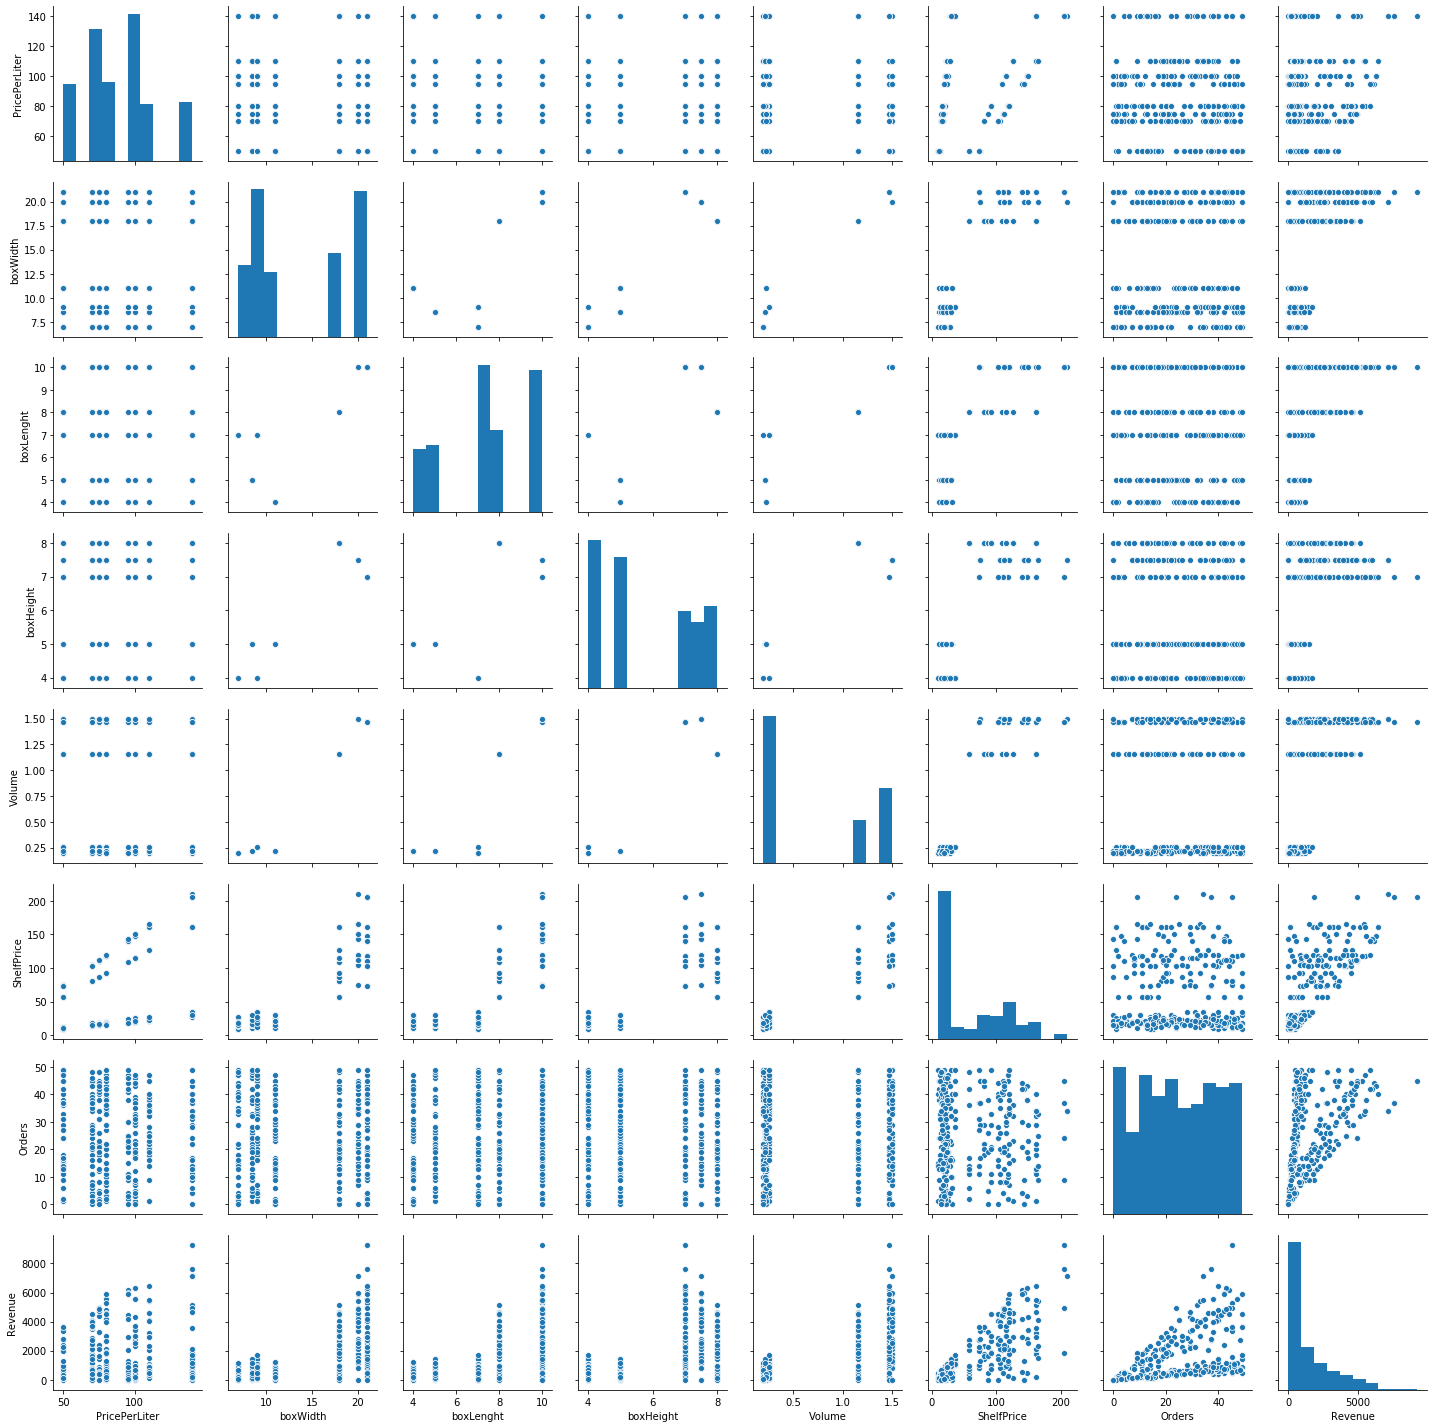

In [4]:
sns.pairplot(df)

Хм, судя по всему, большинство переменных у нас распределены группами:  
Цена за литр, высота, длина, высота, объем и цена распределены неравномерно.  
Взглянем на корреляции между переменными.

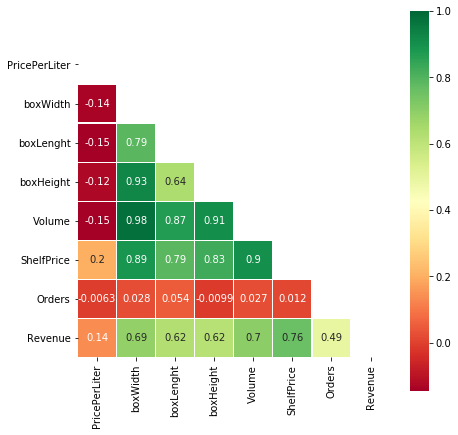

In [5]:
plt.figure(figsize = (7,7))
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(data=corr, mask=mask, annot=True, cmap='RdYlGn', linewidths=0.2, square=True)
plt.show()

Логичным образом, ширина, длина и высота коррелируют с объёмом.   
С целевой переменной **Revenue** сильно корелируют параметры объема, полочная цена.  
Попробуем сделать модель с этими факторами:

In [6]:
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

In [7]:
X = df[[
    "Volume",
    "ShelfPrice"
]]
y = df["Revenue"]
reg = LinearRegression().fit(X, y)

In [8]:
print('Weights: {}'.format(reg.coef_))
print('Bias: {}'.format(reg.intercept_))

pred_values = reg.predict(df[[
    "Volume",
    "ShelfPrice"
]])
print('Error: {}'.format(mean_absolute_error(pred_values, y)))

Weights: [199.37975273  22.72316177]
Bias: -13.765432393116953
Error: 748.144208857632


Большая ошибка. Продолжаем.

Попробуем сделать сборный показатель - объем * на кол-во заказов:

In [9]:
df["VolumeOrders"] = df.Volume * df.Orders

In [10]:
X = df[["VolumeOrders"]]
y = df.Revenue
reg = LinearRegression().fit(X, y)
pred_values = reg.predict(df[["VolumeOrders"]])

m_weights = reg.coef_
m_bias = reg.intercept_
m_error = mean_absolute_error(pred_values, y)
print(
f"Weights: {m_weights}, \n"
f"Bias: {m_bias:2.4f}, \n"
f"Error: {m_error:2.4f}"
)

Weights: [80.90153389], 
Bias: 69.8643, 
Error: 363.4027


Лучше, но есть куда стремиться.  
Попробуем цену за литр скрестить с объемом продаж: 

In [11]:
df["PriceOrders"] = df.PricePerLiter * df.Orders

In [12]:
X = df[["PriceOrders"]]
y = df.Revenue
reg = LinearRegression().fit(X, y)
pred_values = reg.predict(df[["PriceOrders"]])

m_weights = reg.coef_
m_bias = reg.intercept_
m_error = mean_absolute_error(pred_values, y)
print(
f"Weights: {m_weights}, \n"
f"Bias: {m_bias:2.4f}, \n"
f"Error: {m_error:2.4f}"
)

Weights: [0.57600868], 
Bias: 295.0732, 
Error: 1220.7791


Стало хуже...  
Ок, скрестим все три параметра - цену за литр, объем упаковки и объем продаж:

In [13]:
df["PriceVolumeOrders"] = df.PricePerLiter * df.Volume * df.Orders

In [14]:
X = df[["PriceVolumeOrders"]]
y = df.Revenue
reg = LinearRegression().fit(X, y)
pred_values = reg.predict(df[["PriceVolumeOrders"]])

m_weights = reg.coef_
m_bias = reg.intercept_
m_error = mean_absolute_error(pred_values, y)
print(
f"Weights: {m_weights}, \n"
f"Bias: {m_bias:2.4f}, \n"
f"Error: {m_error:2.4f}"
)


Weights: [1.], 
Bias: 0.0000, 
Error: 0.0000


Попали в цель! =)